In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import pcraster as pcr
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
# import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
# from pcrglobwb_203_30min_2way import pcrglobwb_bmi
# from pcrglobwb_203_30min_2way import disclaimer
import model as pcrglobwb_bmi_v203
from model import pcrglobwb_bmi
from model import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import utils
from coupling_PCR_FM_2way import configuration
%config Application.log_level="INFO"

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

# arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'
arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment_LFP.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
    use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

couple_channelStorage = True

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])
LDD                 = os.path.join(inputDIR, configPCR.routingOptions['lddMap'])

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-02-23 14:38:04,301 model.disclaimer INFO 

 PCR-GLOBWB (PCRaster Global Water Balance) Global Hydrological Model                       

 Copyright (C) 2016, Ludovicus P. H. (Rens) van Beek, Edwin H. Sutanudjaja, Yoshihide Wada, 
 Joyce H. C. Bosmans, Niels Drost, Inge E. M. de Graaf, Kor de Jong, Patricia Lopez Lopez,  
 Stefanie Pessenteiner, Oliver Schmitz, Menno W. Straatsma, Niko Wanders, Dominik Wisser,   
 and Marc F. P. Bierkens,                                                                   
 Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands                       

 This program comes with ABSOLUTELY NO WARRANTY                                             
 This is free software, and you are welcome to redistribute it under certain conditions     
 See the LICENSE file for more details                                                      


2018-02-23 14:38:04,302 model.configuration INFO Model run started at 2018-02-23 14:38:04.272926
2018-02-23 14:


##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  LFP_AMA_test2way.par
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-02-23 14:38:04.272520



2018-02-23 14:38:04,810 model.meteo INFO No forcing downscaling is implemented.
2018-02-23 14:38:04,982 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-23 14:38:04,984 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-23 14:38:04,985 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-23 14:38:04,986 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-23 14:38:04,987 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-23 14:38:04,993 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-23 14:38:04,996 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-23 14:38:07,431 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa


>>> PCR Initialized <<<



2018-02-23 14:38:14,450 model.meteo INFO No forcing downscaling is implemented.
2018-02-23 14:38:14,603 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-23 14:38:14,606 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-23 14:38:14,607 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-23 14:38:14,609 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-23 14:38:14,611 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-23 14:38:14,618 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-23 14:38:14,621 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-23 14:38:17,079 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa

2018-02-23 14:38:28,138 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-23 14:38:28,215 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-23 14:38:28,347 model.groundwater INFO Updating groundwater
2018-02-23 14:38:28,354 model.routing INFO routing in progress
2018-02-23 14:38:28,357 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:28,368 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:28,386 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:28,403 model.routing INFO sub-daily t

2018-02-23 14:38:30,707 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-23 14:38:30,787 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-23 14:38:30,917 model.groundwater INFO Updating groundwater
2018-02-23 14:38:30,922 model.routing INFO routing in progress
2018-02-23 14:38:30,926 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:30,936 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:30,954 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:30,971 model.routing INFO sub-daily t

2018-02-23 14:38:33,374 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-23 14:38:33,454 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-23 14:38:33,590 model.groundwater INFO Updating groundwater
2018-02-23 14:38:33,595 model.routing INFO routing in progress
2018-02-23 14:38:33,599 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:33,610 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:33,627 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:33,642 model.routing INFO sub-daily t

2018-02-23 14:38:35,896 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-23 14:38:35,983 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-23 14:38:36,121 model.groundwater INFO Updating groundwater
2018-02-23 14:38:36,128 model.routing INFO routing in progress
2018-02-23 14:38:36,131 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:36,143 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:36,162 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:36,180 model.routing INFO sub-daily t

2018-02-23 14:38:38,566 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-23 14:38:38,647 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-23 14:38:38,790 model.groundwater INFO Updating groundwater
2018-02-23 14:38:38,795 model.routing INFO routing in progress
2018-02-23 14:38:38,798 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:38,809 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:38,826 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:38,842 model.routing INFO sub-daily

2018-02-23 14:38:41,294 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-23 14:38:41,380 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-23 14:38:41,517 model.groundwater INFO Updating groundwater
2018-02-23 14:38:41,522 model.routing INFO routing in progress
2018-02-23 14:38:41,526 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:41,537 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:41,554 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:41,573 model.routing INFO sub-daily

2018-02-23 14:38:43,988 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-23 14:38:44,067 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-23 14:38:44,231 model.groundwater INFO Updating groundwater
2018-02-23 14:38:44,239 model.routing INFO routing in progress
2018-02-23 14:38:44,243 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:44,254 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:44,271 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:44,288 model.routing INFO sub-daily

2018-02-23 14:38:46,640 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-23 14:38:46,730 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-23 14:38:46,867 model.groundwater INFO Updating groundwater
2018-02-23 14:38:46,872 model.routing INFO routing in progress
2018-02-23 14:38:46,875 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:46,887 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:46,904 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:46,921 model.routing INFO sub-daily

2018-02-23 14:38:49,361 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-23 14:38:49,445 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-23 14:38:49,593 model.groundwater INFO Updating groundwater
2018-02-23 14:38:49,600 model.routing INFO routing in progress
2018-02-23 14:38:49,605 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:49,617 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:49,635 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:49,654 model.routing INFO sub-daily

2018-02-23 14:38:52,137 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-23 14:38:52,215 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-23 14:38:52,364 model.groundwater INFO Updating groundwater
2018-02-23 14:38:52,372 model.routing INFO routing in progress
2018-02-23 14:38:52,379 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:52,393 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:52,412 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:52,430 model.routing INFO sub-daily

2018-02-23 14:38:54,853 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-23 14:38:54,936 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-23 14:38:55,069 model.groundwater INFO Updating groundwater
2018-02-23 14:38:55,075 model.routing INFO routing in progress
2018-02-23 14:38:55,078 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:55,088 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:55,104 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:55,120 model.routing INFO sub-daily

2018-02-23 14:38:57,439 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-23 14:38:57,518 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-23 14:38:57,662 model.groundwater INFO Updating groundwater
2018-02-23 14:38:57,668 model.routing INFO routing in progress
2018-02-23 14:38:57,671 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:38:57,680 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:38:57,699 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:38:57,719 model.routing INFO sub-daily

2018-02-23 14:39:00,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-23 14:39:00,230 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-23 14:39:00,373 model.groundwater INFO Updating groundwater
2018-02-23 14:39:00,381 model.routing INFO routing in progress
2018-02-23 14:39:00,384 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:00,396 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:00,414 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:00,432 model.routing INFO sub-daily

2018-02-23 14:39:02,757 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-23 14:39:02,829 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-23 14:39:02,975 model.groundwater INFO Updating groundwater
2018-02-23 14:39:02,982 model.routing INFO routing in progress
2018-02-23 14:39:02,985 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:02,997 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:03,013 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:03,031 model.routing INFO sub-daily

2018-02-23 14:39:05,414 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-23 14:39:05,496 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-23 14:39:05,631 model.groundwater INFO Updating groundwater
2018-02-23 14:39:05,637 model.routing INFO routing in progress
2018-02-23 14:39:05,640 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:05,650 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:05,667 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:05,684 model.routing INFO sub-daily

2018-02-23 14:39:08,040 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-23 14:39:08,127 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-23 14:39:08,274 model.groundwater INFO Updating groundwater
2018-02-23 14:39:08,282 model.routing INFO routing in progress
2018-02-23 14:39:08,287 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:08,301 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:08,402 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:08,515 model.routing INFO sub-daily t

2018-02-23 14:39:12,768 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-23 14:39:12,852 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-23 14:39:12,990 model.groundwater INFO Updating groundwater
2018-02-23 14:39:12,995 model.routing INFO routing in progress
2018-02-23 14:39:12,998 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:13,009 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:13,025 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:13,044 model.routing INFO sub-daily t

2018-02-23 14:39:15,495 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-23 14:39:15,589 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-23 14:39:15,738 model.groundwater INFO Updating groundwater
2018-02-23 14:39:15,746 model.routing INFO routing in progress
2018-02-23 14:39:15,752 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:15,766 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:15,786 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:15,806 model.routing INFO sub-daily t

2018-02-23 14:39:18,306 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-23 14:39:18,389 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-23 14:39:18,524 model.groundwater INFO Updating groundwater
2018-02-23 14:39:18,533 model.routing INFO routing in progress
2018-02-23 14:39:18,539 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:18,552 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:18,570 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:18,587 model.routing INFO sub-daily t

2018-02-23 14:39:20,983 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-23 14:39:21,079 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-23 14:39:21,229 model.groundwater INFO Updating groundwater
2018-02-23 14:39:21,235 model.routing INFO routing in progress
2018-02-23 14:39:21,238 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:21,249 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:21,266 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:21,283 model.routing INFO sub-daily t

2018-02-23 14:39:23,633 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-23 14:39:23,716 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-23 14:39:23,851 model.groundwater INFO Updating groundwater
2018-02-23 14:39:23,857 model.routing INFO routing in progress
2018-02-23 14:39:23,860 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:23,868 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:23,882 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:23,895 model.routing INFO sub-daily

2018-02-23 14:39:26,170 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-23 14:39:26,264 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-23 14:39:26,407 model.groundwater INFO Updating groundwater
2018-02-23 14:39:26,415 model.routing INFO routing in progress
2018-02-23 14:39:26,419 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:26,431 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:26,449 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:26,467 model.routing INFO sub-daily

2018-02-23 14:39:28,832 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-23 14:39:28,892 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-23 14:39:29,026 model.groundwater INFO Updating groundwater
2018-02-23 14:39:29,033 model.routing INFO routing in progress
2018-02-23 14:39:29,037 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:29,048 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:29,065 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:29,082 model.routing INFO sub-daily

2018-02-23 14:39:31,439 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-23 14:39:31,498 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-23 14:39:31,651 model.groundwater INFO Updating groundwater
2018-02-23 14:39:31,657 model.routing INFO routing in progress
2018-02-23 14:39:31,661 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:31,673 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:31,691 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:31,708 model.routing INFO sub-daily

2018-02-23 14:39:33,976 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-23 14:39:34,055 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-23 14:39:34,186 model.groundwater INFO Updating groundwater
2018-02-23 14:39:34,193 model.routing INFO routing in progress
2018-02-23 14:39:34,197 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:34,209 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:34,226 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:34,244 model.routing INFO sub-daily

2018-02-23 14:39:36,723 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-23 14:39:36,810 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-23 14:39:36,946 model.groundwater INFO Updating groundwater
2018-02-23 14:39:36,953 model.routing INFO routing in progress
2018-02-23 14:39:36,957 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:36,969 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:36,986 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:37,005 model.routing INFO sub-daily

2018-02-23 14:39:39,400 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-23 14:39:39,477 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-23 14:39:39,619 model.groundwater INFO Updating groundwater
2018-02-23 14:39:39,624 model.routing INFO routing in progress
2018-02-23 14:39:39,627 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:39,638 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:39,655 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:39,673 model.routing INFO sub-daily

2018-02-23 14:39:42,001 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-23 14:39:42,090 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-23 14:39:42,260 model.groundwater INFO Updating groundwater
2018-02-23 14:39:42,267 model.routing INFO routing in progress
2018-02-23 14:39:42,270 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:42,282 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:42,300 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:42,316 model.routing INFO sub-daily

2018-02-23 14:39:44,693 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-23 14:39:44,777 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-23 14:39:44,932 model.groundwater INFO Updating groundwater
2018-02-23 14:39:44,938 model.routing INFO routing in progress
2018-02-23 14:39:44,941 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:44,951 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:44,967 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:44,984 model.routing INFO sub-daily

2018-02-23 14:39:47,415 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-23 14:39:47,503 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-23 14:39:47,646 model.groundwater INFO Updating groundwater
2018-02-23 14:39:47,652 model.routing INFO routing in progress
2018-02-23 14:39:47,656 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:47,667 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:47,686 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:47,701 model.routing INFO sub-daily

2018-02-23 14:39:52,127 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-23 14:39:52,206 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-23 14:39:52,351 model.groundwater INFO Updating groundwater
2018-02-23 14:39:52,356 model.routing INFO routing in progress
2018-02-23 14:39:52,359 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:52,369 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:52,385 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:52,403 model.routing INFO sub-daily t

2018-02-23 14:39:54,742 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-23 14:39:54,820 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-23 14:39:54,954 model.groundwater INFO Updating groundwater
2018-02-23 14:39:54,960 model.routing INFO routing in progress
2018-02-23 14:39:54,963 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:54,974 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:54,990 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:55,006 model.routing INFO sub-daily t

2018-02-23 14:39:57,430 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-23 14:39:57,511 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-23 14:39:57,655 model.groundwater INFO Updating groundwater
2018-02-23 14:39:57,662 model.routing INFO routing in progress
2018-02-23 14:39:57,665 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:39:57,678 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:39:57,695 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:39:57,714 model.routing INFO sub-daily t

2018-02-23 14:40:00,051 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-23 14:40:00,141 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-23 14:40:00,278 model.groundwater INFO Updating groundwater
2018-02-23 14:40:00,285 model.routing INFO routing in progress
2018-02-23 14:40:00,291 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:00,303 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:00,321 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:00,339 model.routing INFO sub-daily t

2018-02-23 14:40:02,747 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-23 14:40:02,824 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-23 14:40:02,969 model.groundwater INFO Updating groundwater
2018-02-23 14:40:02,975 model.routing INFO routing in progress
2018-02-23 14:40:02,978 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:02,990 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:03,008 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:03,025 model.routing INFO sub-daily

2018-02-23 14:40:05,271 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-23 14:40:05,350 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-23 14:40:05,499 model.groundwater INFO Updating groundwater
2018-02-23 14:40:05,505 model.routing INFO routing in progress
2018-02-23 14:40:05,508 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:05,519 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:05,535 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:05,553 model.routing INFO sub-daily

2018-02-23 14:40:07,887 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-23 14:40:07,970 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-23 14:40:08,101 model.groundwater INFO Updating groundwater
2018-02-23 14:40:08,106 model.routing INFO routing in progress
2018-02-23 14:40:08,110 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:08,121 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:08,137 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:08,154 model.routing INFO sub-daily

2018-02-23 14:40:10,557 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-23 14:40:10,638 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-23 14:40:10,775 model.groundwater INFO Updating groundwater
2018-02-23 14:40:10,781 model.routing INFO routing in progress
2018-02-23 14:40:10,784 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:10,795 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:10,813 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:10,831 model.routing INFO sub-daily

2018-02-23 14:40:13,210 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-23 14:40:13,301 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-23 14:40:13,441 model.groundwater INFO Updating groundwater
2018-02-23 14:40:13,449 model.routing INFO routing in progress
2018-02-23 14:40:13,453 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:13,465 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:13,484 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:13,502 model.routing INFO sub-daily

2018-02-23 14:40:15,805 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-23 14:40:15,881 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-23 14:40:16,016 model.groundwater INFO Updating groundwater
2018-02-23 14:40:16,021 model.routing INFO routing in progress
2018-02-23 14:40:16,023 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:16,034 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:16,049 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:16,065 model.routing INFO sub-daily

2018-02-23 14:40:18,396 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-23 14:40:18,481 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-23 14:40:18,619 model.groundwater INFO Updating groundwater
2018-02-23 14:40:18,625 model.routing INFO routing in progress
2018-02-23 14:40:18,628 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:18,639 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:18,656 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:18,673 model.routing INFO sub-daily

2018-02-23 14:40:21,024 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-23 14:40:21,101 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-23 14:40:21,237 model.groundwater INFO Updating groundwater
2018-02-23 14:40:21,243 model.routing INFO routing in progress
2018-02-23 14:40:21,247 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:21,259 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:21,276 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:21,293 model.routing INFO sub-daily

2018-02-23 14:40:23,620 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-23 14:40:23,693 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-23 14:40:23,837 model.groundwater INFO Updating groundwater
2018-02-23 14:40:23,844 model.routing INFO routing in progress
2018-02-23 14:40:23,847 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:23,859 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:23,876 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:23,894 model.routing INFO sub-daily

2018-02-23 14:40:26,231 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-23 14:40:26,316 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-23 14:40:26,469 model.groundwater INFO Updating groundwater
2018-02-23 14:40:26,475 model.routing INFO routing in progress
2018-02-23 14:40:26,478 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:26,491 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:26,512 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:26,529 model.routing INFO sub-daily

2018-02-23 14:40:28,973 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-23 14:40:29,052 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-23 14:40:29,191 model.groundwater INFO Updating groundwater
2018-02-23 14:40:29,197 model.routing INFO routing in progress
2018-02-23 14:40:29,200 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:29,211 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:29,227 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:29,244 model.routing INFO sub-daily

2018-02-23 14:40:31,697 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-23 14:40:31,775 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-23 14:40:31,914 model.groundwater INFO Updating groundwater
2018-02-23 14:40:31,920 model.routing INFO routing in progress
2018-02-23 14:40:31,923 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:31,934 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:32,029 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:32,124 model.routing INFO sub-daily t

2018-02-23 14:40:36,395 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-23 14:40:36,485 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-23 14:40:36,632 model.groundwater INFO Updating groundwater
2018-02-23 14:40:36,638 model.routing INFO routing in progress
2018-02-23 14:40:36,642 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:36,653 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:36,671 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:36,688 model.routing INFO sub-daily t

2018-02-23 14:40:39,072 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-23 14:40:39,163 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-23 14:40:39,305 model.groundwater INFO Updating groundwater
2018-02-23 14:40:39,312 model.routing INFO routing in progress
2018-02-23 14:40:39,315 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:39,326 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:39,345 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:39,361 model.routing INFO sub-daily t

2018-02-23 14:40:41,791 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-23 14:40:41,875 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-23 14:40:42,016 model.groundwater INFO Updating groundwater
2018-02-23 14:40:42,022 model.routing INFO routing in progress
2018-02-23 14:40:42,025 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:42,036 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:42,052 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:42,069 model.routing INFO sub-daily t

2018-02-23 14:40:44,493 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-23 14:40:44,569 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-23 14:40:44,704 model.groundwater INFO Updating groundwater
2018-02-23 14:40:44,710 model.routing INFO routing in progress
2018-02-23 14:40:44,713 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:44,724 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:44,741 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:44,757 model.routing INFO sub-daily t

2018-02-23 14:40:47,213 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-23 14:40:47,296 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-23 14:40:47,435 model.groundwater INFO Updating groundwater
2018-02-23 14:40:47,440 model.routing INFO routing in progress
2018-02-23 14:40:47,443 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:47,454 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:47,476 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:47,498 model.routing INFO sub-daily

2018-02-23 14:40:49,896 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-23 14:40:49,985 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-23 14:40:50,132 model.groundwater INFO Updating groundwater
2018-02-23 14:40:50,138 model.routing INFO routing in progress
2018-02-23 14:40:50,142 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:50,154 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:50,171 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:50,187 model.routing INFO sub-daily

2018-02-23 14:40:52,595 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-23 14:40:52,674 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-23 14:40:52,808 model.groundwater INFO Updating groundwater
2018-02-23 14:40:52,814 model.routing INFO routing in progress
2018-02-23 14:40:52,817 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:52,828 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:52,844 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:52,860 model.routing INFO sub-daily

2018-02-23 14:40:55,362 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-23 14:40:55,441 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-23 14:40:55,574 model.groundwater INFO Updating groundwater
2018-02-23 14:40:55,579 model.routing INFO routing in progress
2018-02-23 14:40:55,582 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:55,593 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:55,608 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:55,624 model.routing INFO sub-daily

2018-02-23 14:40:58,001 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-23 14:40:58,085 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-23 14:40:58,225 model.groundwater INFO Updating groundwater
2018-02-23 14:40:58,231 model.routing INFO routing in progress
2018-02-23 14:40:58,234 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:40:58,246 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:40:58,263 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:40:58,279 model.routing INFO sub-daily

2018-02-23 14:41:00,662 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-23 14:41:00,745 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-23 14:41:00,883 model.groundwater INFO Updating groundwater
2018-02-23 14:41:00,890 model.routing INFO routing in progress
2018-02-23 14:41:00,895 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:00,907 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:00,925 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:00,943 model.routing INFO sub-daily

2018-02-23 14:41:03,359 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-23 14:41:03,450 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-23 14:41:03,584 model.groundwater INFO Updating groundwater
2018-02-23 14:41:03,590 model.routing INFO routing in progress
2018-02-23 14:41:03,594 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:03,605 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:03,618 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:03,632 model.routing INFO sub-daily

2018-02-23 14:41:05,959 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-23 14:41:06,037 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-23 14:41:06,186 model.groundwater INFO Updating groundwater
2018-02-23 14:41:06,193 model.routing INFO routing in progress
2018-02-23 14:41:06,196 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:06,207 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:06,225 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:06,241 model.routing INFO sub-daily

2018-02-23 14:41:08,687 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-23 14:41:08,767 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-23 14:41:08,906 model.groundwater INFO Updating groundwater
2018-02-23 14:41:08,911 model.routing INFO routing in progress
2018-02-23 14:41:08,914 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:08,925 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:08,941 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:08,957 model.routing INFO sub-daily

2018-02-23 14:41:11,376 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-23 14:41:11,459 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-23 14:41:11,593 model.groundwater INFO Updating groundwater
2018-02-23 14:41:11,599 model.routing INFO routing in progress
2018-02-23 14:41:11,603 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:11,614 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:11,630 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:11,648 model.routing INFO sub-daily

2018-02-23 14:41:14,062 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-23 14:41:14,147 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-23 14:41:14,306 model.groundwater INFO Updating groundwater
2018-02-23 14:41:14,312 model.routing INFO routing in progress
2018-02-23 14:41:14,316 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:14,328 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:14,421 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:14,513 model.routing INFO sub-daily t

2018-02-23 14:41:18,515 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-23 14:41:18,595 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-23 14:41:18,733 model.groundwater INFO Updating groundwater
2018-02-23 14:41:18,739 model.routing INFO routing in progress
2018-02-23 14:41:18,743 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:18,755 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:18,772 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:18,790 model.routing INFO sub-daily t

2018-02-23 14:41:21,209 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-23 14:41:21,289 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-23 14:41:21,422 model.groundwater INFO Updating groundwater
2018-02-23 14:41:21,428 model.routing INFO routing in progress
2018-02-23 14:41:21,431 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:21,442 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:21,457 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:21,474 model.routing INFO sub-daily t

2018-02-23 14:41:23,837 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-23 14:41:23,919 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-23 14:41:24,056 model.groundwater INFO Updating groundwater
2018-02-23 14:41:24,064 model.routing INFO routing in progress
2018-02-23 14:41:24,069 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:24,081 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:24,099 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:24,117 model.routing INFO sub-daily t

2018-02-23 14:41:26,532 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-23 14:41:26,619 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-23 14:41:26,760 model.groundwater INFO Updating groundwater
2018-02-23 14:41:26,768 model.routing INFO routing in progress
2018-02-23 14:41:26,773 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:26,788 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:26,805 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:26,822 model.routing INFO sub-daily t

2018-02-23 14:41:29,172 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-23 14:41:29,254 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-23 14:41:29,387 model.groundwater INFO Updating groundwater
2018-02-23 14:41:29,393 model.routing INFO routing in progress
2018-02-23 14:41:29,396 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:29,407 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:29,425 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:29,443 model.routing INFO sub-daily

2018-02-23 14:41:31,709 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-23 14:41:31,792 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-23 14:41:31,915 model.groundwater INFO Updating groundwater
2018-02-23 14:41:31,920 model.routing INFO routing in progress
2018-02-23 14:41:31,922 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:31,931 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:31,945 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:31,958 model.routing INFO sub-daily

2018-02-23 14:41:34,282 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-23 14:41:34,374 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-23 14:41:34,509 model.groundwater INFO Updating groundwater
2018-02-23 14:41:34,515 model.routing INFO routing in progress
2018-02-23 14:41:34,518 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:34,529 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:34,546 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:34,562 model.routing INFO sub-daily

2018-02-23 14:41:36,832 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-23 14:41:36,913 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-23 14:41:37,050 model.groundwater INFO Updating groundwater
2018-02-23 14:41:37,058 model.routing INFO routing in progress
2018-02-23 14:41:37,063 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:37,076 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:37,093 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:37,110 model.routing INFO sub-daily

2018-02-23 14:41:39,520 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-23 14:41:39,597 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-23 14:41:39,726 model.groundwater INFO Updating groundwater
2018-02-23 14:41:39,738 model.routing INFO routing in progress
2018-02-23 14:41:39,743 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:39,754 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:39,771 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:39,789 model.routing INFO sub-daily

2018-02-23 14:41:42,288 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-23 14:41:42,371 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-23 14:41:42,519 model.groundwater INFO Updating groundwater
2018-02-23 14:41:42,525 model.routing INFO routing in progress
2018-02-23 14:41:42,528 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:42,539 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:42,556 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:42,576 model.routing INFO sub-daily

2018-02-23 14:41:44,955 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-23 14:41:45,043 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-23 14:41:45,173 model.groundwater INFO Updating groundwater
2018-02-23 14:41:45,179 model.routing INFO routing in progress
2018-02-23 14:41:45,182 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:45,192 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:45,209 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:45,225 model.routing INFO sub-daily

2018-02-23 14:41:47,521 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-23 14:41:47,609 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-23 14:41:47,745 model.groundwater INFO Updating groundwater
2018-02-23 14:41:47,753 model.routing INFO routing in progress
2018-02-23 14:41:47,758 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:47,771 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:47,789 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:47,806 model.routing INFO sub-daily

2018-02-23 14:41:50,226 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-23 14:41:50,309 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-23 14:41:50,451 model.groundwater INFO Updating groundwater
2018-02-23 14:41:50,459 model.routing INFO routing in progress
2018-02-23 14:41:50,465 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:50,479 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:50,499 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:50,518 model.routing INFO sub-daily

2018-02-23 14:41:52,880 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-23 14:41:52,969 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-23 14:41:53,110 model.groundwater INFO Updating groundwater
2018-02-23 14:41:53,116 model.routing INFO routing in progress
2018-02-23 14:41:53,120 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:53,130 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:53,148 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:53,165 model.routing INFO sub-daily

2018-02-23 14:41:55,637 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-23 14:41:55,727 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-23 14:41:55,870 model.groundwater INFO Updating groundwater
2018-02-23 14:41:55,878 model.routing INFO routing in progress
2018-02-23 14:41:55,884 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:41:55,899 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:41:55,917 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:41:55,937 model.routing INFO sub-daily

2018-02-23 14:42:00,316 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-23 14:42:00,402 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-23 14:42:00,542 model.groundwater INFO Updating groundwater
2018-02-23 14:42:00,549 model.routing INFO routing in progress
2018-02-23 14:42:00,554 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:00,566 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:00,585 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:00,602 model.routing INFO sub-daily t

2018-02-23 14:42:02,917 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-23 14:42:02,994 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-23 14:42:03,136 model.groundwater INFO Updating groundwater
2018-02-23 14:42:03,142 model.routing INFO routing in progress
2018-02-23 14:42:03,145 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:03,156 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:03,171 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:03,187 model.routing INFO sub-daily t

2018-02-23 14:42:05,588 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-23 14:42:05,667 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-23 14:42:05,811 model.groundwater INFO Updating groundwater
2018-02-23 14:42:05,817 model.routing INFO routing in progress
2018-02-23 14:42:05,820 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:05,831 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:05,847 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:05,863 model.routing INFO sub-daily t

2018-02-23 14:42:08,274 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-23 14:42:08,362 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-23 14:42:08,504 model.groundwater INFO Updating groundwater
2018-02-23 14:42:08,517 model.routing INFO routing in progress
2018-02-23 14:42:08,522 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:08,534 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:08,551 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:08,576 model.routing INFO sub-daily t

2018-02-23 14:42:10,911 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-23 14:42:10,994 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-23 14:42:11,136 model.groundwater INFO Updating groundwater
2018-02-23 14:42:11,141 model.routing INFO routing in progress
2018-02-23 14:42:11,145 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:11,155 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:11,172 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:11,189 model.routing INFO sub-daily

2018-02-23 14:42:13,644 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-23 14:42:13,730 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-23 14:42:13,872 model.groundwater INFO Updating groundwater
2018-02-23 14:42:13,878 model.routing INFO routing in progress
2018-02-23 14:42:13,881 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:13,892 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:13,910 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:13,928 model.routing INFO sub-daily

2018-02-23 14:42:16,296 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-23 14:42:16,376 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-23 14:42:16,530 model.groundwater INFO Updating groundwater
2018-02-23 14:42:16,536 model.routing INFO routing in progress
2018-02-23 14:42:16,540 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:16,550 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:16,566 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:16,582 model.routing INFO sub-daily

2018-02-23 14:42:18,897 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-23 14:42:18,986 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-23 14:42:19,130 model.groundwater INFO Updating groundwater
2018-02-23 14:42:19,136 model.routing INFO routing in progress
2018-02-23 14:42:19,139 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:19,150 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:19,168 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:19,186 model.routing INFO sub-daily

2018-02-23 14:42:21,606 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-23 14:42:21,685 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-23 14:42:21,822 model.groundwater INFO Updating groundwater
2018-02-23 14:42:21,831 model.routing INFO routing in progress
2018-02-23 14:42:21,836 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:21,850 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:21,869 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:21,888 model.routing INFO sub-daily

2018-02-23 14:42:24,235 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-23 14:42:24,314 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-23 14:42:24,453 model.groundwater INFO Updating groundwater
2018-02-23 14:42:24,458 model.routing INFO routing in progress
2018-02-23 14:42:24,461 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:24,472 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:24,489 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:24,502 model.routing INFO sub-daily

2018-02-23 14:42:26,906 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-23 14:42:27,010 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-23 14:42:27,145 model.groundwater INFO Updating groundwater
2018-02-23 14:42:27,151 model.routing INFO routing in progress
2018-02-23 14:42:27,154 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:27,165 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:27,183 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:27,200 model.routing INFO sub-daily

2018-02-23 14:42:29,593 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-23 14:42:29,680 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-23 14:42:29,822 model.groundwater INFO Updating groundwater
2018-02-23 14:42:29,828 model.routing INFO routing in progress
2018-02-23 14:42:29,835 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:29,846 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:29,865 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:29,883 model.routing INFO sub-daily

2018-02-23 14:42:32,222 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-23 14:42:32,301 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-23 14:42:32,437 model.groundwater INFO Updating groundwater
2018-02-23 14:42:32,442 model.routing INFO routing in progress
2018-02-23 14:42:32,445 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:32,456 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:32,472 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:32,488 model.routing INFO sub-daily

2018-02-23 14:42:34,877 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-23 14:42:34,962 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-23 14:42:35,100 model.groundwater INFO Updating groundwater
2018-02-23 14:42:35,106 model.routing INFO routing in progress
2018-02-23 14:42:35,109 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:35,119 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:35,135 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:35,152 model.routing INFO sub-daily

2018-02-23 14:42:37,601 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-23 14:42:37,680 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-23 14:42:37,819 model.groundwater INFO Updating groundwater
2018-02-23 14:42:37,825 model.routing INFO routing in progress
2018-02-23 14:42:37,829 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:37,841 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:37,857 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:37,874 model.routing INFO sub-daily

2018-02-23 14:42:42,227 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-23 14:42:42,310 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-23 14:42:42,447 model.groundwater INFO Updating groundwater
2018-02-23 14:42:42,452 model.routing INFO routing in progress
2018-02-23 14:42:42,455 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:42,466 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:42,483 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:42,499 model.routing INFO sub-daily t

2018-02-23 14:42:44,936 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-23 14:42:45,015 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-23 14:42:45,160 model.groundwater INFO Updating groundwater
2018-02-23 14:42:45,167 model.routing INFO routing in progress
2018-02-23 14:42:45,172 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:45,185 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:45,203 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:45,222 model.routing INFO sub-daily t

2018-02-23 14:42:47,690 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-23 14:42:47,784 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-23 14:42:47,932 model.groundwater INFO Updating groundwater
2018-02-23 14:42:47,938 model.routing INFO routing in progress
2018-02-23 14:42:47,942 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:47,953 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:47,969 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:47,985 model.routing INFO sub-daily t

2018-02-23 14:42:50,427 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-23 14:42:50,506 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-23 14:42:50,641 model.groundwater INFO Updating groundwater
2018-02-23 14:42:50,647 model.routing INFO routing in progress
2018-02-23 14:42:50,650 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:50,661 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:50,678 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:50,694 model.routing INFO sub-daily t

2018-02-23 14:42:53,103 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-23 14:42:53,192 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-23 14:42:53,336 model.groundwater INFO Updating groundwater
2018-02-23 14:42:53,342 model.routing INFO routing in progress
2018-02-23 14:42:53,345 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:53,356 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:53,373 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:53,390 model.routing INFO sub-daily

2018-02-23 14:42:55,808 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-23 14:42:55,887 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-23 14:42:56,032 model.groundwater INFO Updating groundwater
2018-02-23 14:42:56,037 model.routing INFO routing in progress
2018-02-23 14:42:56,040 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:56,051 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:56,067 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:56,083 model.routing INFO sub-daily

2018-02-23 14:42:58,384 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-23 14:42:58,469 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-23 14:42:58,603 model.groundwater INFO Updating groundwater
2018-02-23 14:42:58,608 model.routing INFO routing in progress
2018-02-23 14:42:58,611 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:42:58,622 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:42:58,638 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:42:58,664 model.routing INFO sub-daily

2018-02-23 14:43:00,906 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-23 14:43:00,985 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-23 14:43:01,128 model.groundwater INFO Updating groundwater
2018-02-23 14:43:01,134 model.routing INFO routing in progress
2018-02-23 14:43:01,137 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:01,148 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:01,165 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:01,183 model.routing INFO sub-daily

2018-02-23 14:43:03,576 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-23 14:43:03,673 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-23 14:43:03,819 model.groundwater INFO Updating groundwater
2018-02-23 14:43:03,826 model.routing INFO routing in progress
2018-02-23 14:43:03,829 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:03,837 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:03,851 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:03,865 model.routing INFO sub-daily

2018-02-23 14:43:06,171 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-23 14:43:06,257 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-23 14:43:06,390 model.groundwater INFO Updating groundwater
2018-02-23 14:43:06,397 model.routing INFO routing in progress
2018-02-23 14:43:06,402 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:06,416 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:06,434 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:06,452 model.routing INFO sub-daily

2018-02-23 14:43:08,852 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-23 14:43:08,937 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-23 14:43:09,086 model.groundwater INFO Updating groundwater
2018-02-23 14:43:09,092 model.routing INFO routing in progress
2018-02-23 14:43:09,095 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:09,105 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:09,122 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:09,138 model.routing INFO sub-daily

2018-02-23 14:43:11,531 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-23 14:43:11,611 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-23 14:43:11,747 model.groundwater INFO Updating groundwater
2018-02-23 14:43:11,753 model.routing INFO routing in progress
2018-02-23 14:43:11,756 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:11,766 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:11,783 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:11,800 model.routing INFO sub-daily

2018-02-23 14:43:14,265 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-23 14:43:14,345 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-23 14:43:14,485 model.groundwater INFO Updating groundwater
2018-02-23 14:43:14,491 model.routing INFO routing in progress
2018-02-23 14:43:14,495 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:14,505 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:14,521 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:14,538 model.routing INFO sub-daily

2018-02-23 14:43:16,928 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-23 14:43:17,017 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-23 14:43:17,159 model.groundwater INFO Updating groundwater
2018-02-23 14:43:17,165 model.routing INFO routing in progress
2018-02-23 14:43:17,169 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:17,181 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:17,198 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:17,214 model.routing INFO sub-daily

2018-02-23 14:43:19,605 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-23 14:43:19,685 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-23 14:43:19,783 model.groundwater INFO Updating groundwater
2018-02-23 14:43:19,788 model.routing INFO routing in progress
2018-02-23 14:43:19,790 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:19,800 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:19,813 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:19,826 model.routing INFO sub-daily

2018-02-23 14:43:22,196 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-23 14:43:22,284 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-23 14:43:22,425 model.groundwater INFO Updating groundwater
2018-02-23 14:43:22,430 model.routing INFO routing in progress
2018-02-23 14:43:22,433 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:22,444 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:22,546 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:22,647 model.routing INFO sub-daily t

2018-02-23 14:43:26,813 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-23 14:43:26,899 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-23 14:43:27,038 model.groundwater INFO Updating groundwater
2018-02-23 14:43:27,044 model.routing INFO routing in progress
2018-02-23 14:43:27,049 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:27,061 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:27,078 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:27,095 model.routing INFO sub-daily t

2018-02-23 14:43:29,464 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-23 14:43:29,548 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-23 14:43:29,697 model.groundwater INFO Updating groundwater
2018-02-23 14:43:29,704 model.routing INFO routing in progress
2018-02-23 14:43:29,708 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:29,719 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:29,736 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:29,754 model.routing INFO sub-daily t

2018-02-23 14:43:32,215 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-23 14:43:32,295 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-23 14:43:32,428 model.groundwater INFO Updating groundwater
2018-02-23 14:43:32,434 model.routing INFO routing in progress
2018-02-23 14:43:32,437 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:32,448 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:32,465 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:32,481 model.routing INFO sub-daily t

2018-02-23 14:43:34,909 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-23 14:43:34,998 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-23 14:43:35,141 model.groundwater INFO Updating groundwater
2018-02-23 14:43:35,149 model.routing INFO routing in progress
2018-02-23 14:43:35,154 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:35,168 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:35,188 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:35,205 model.routing INFO sub-daily t

2018-02-23 14:43:37,645 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-23 14:43:37,729 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-23 14:43:37,863 model.groundwater INFO Updating groundwater
2018-02-23 14:43:37,869 model.routing INFO routing in progress
2018-02-23 14:43:37,873 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:37,884 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:37,902 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:37,918 model.routing INFO sub-daily

2018-02-23 14:43:40,288 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-23 14:43:40,369 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-23 14:43:40,504 model.groundwater INFO Updating groundwater
2018-02-23 14:43:40,509 model.routing INFO routing in progress
2018-02-23 14:43:40,514 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:40,525 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:40,541 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:40,558 model.routing INFO sub-daily

2018-02-23 14:43:43,003 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-23 14:43:43,083 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-23 14:43:43,227 model.groundwater INFO Updating groundwater
2018-02-23 14:43:43,233 model.routing INFO routing in progress
2018-02-23 14:43:43,237 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:43,248 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:43,265 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:43,282 model.routing INFO sub-daily

2018-02-23 14:43:45,633 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-23 14:43:45,716 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-23 14:43:45,855 model.groundwater INFO Updating groundwater
2018-02-23 14:43:45,861 model.routing INFO routing in progress
2018-02-23 14:43:45,864 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:45,875 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:45,893 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:45,911 model.routing INFO sub-daily

2018-02-23 14:43:48,362 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-23 14:43:48,445 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-23 14:43:48,589 model.groundwater INFO Updating groundwater
2018-02-23 14:43:48,598 model.routing INFO routing in progress
2018-02-23 14:43:48,604 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:48,618 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:48,635 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:48,653 model.routing INFO sub-daily

2018-02-23 14:43:51,035 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-23 14:43:51,122 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-23 14:43:51,263 model.groundwater INFO Updating groundwater
2018-02-23 14:43:51,272 model.routing INFO routing in progress
2018-02-23 14:43:51,278 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:51,291 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:51,308 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:51,321 model.routing INFO sub-daily

2018-02-23 14:43:53,622 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-23 14:43:53,714 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-23 14:43:53,850 model.groundwater INFO Updating groundwater
2018-02-23 14:43:53,856 model.routing INFO routing in progress
2018-02-23 14:43:53,859 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:53,870 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:53,887 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:53,904 model.routing INFO sub-daily

2018-02-23 14:43:56,272 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-23 14:43:56,356 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-23 14:43:56,499 model.groundwater INFO Updating groundwater
2018-02-23 14:43:56,504 model.routing INFO routing in progress
2018-02-23 14:43:56,508 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:56,518 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:56,534 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:56,549 model.routing INFO sub-daily

2018-02-23 14:43:58,936 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-23 14:43:59,015 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-23 14:43:59,149 model.groundwater INFO Updating groundwater
2018-02-23 14:43:59,155 model.routing INFO routing in progress
2018-02-23 14:43:59,158 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:43:59,169 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:43:59,186 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:43:59,202 model.routing INFO sub-daily

2018-02-23 14:44:01,659 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-23 14:44:01,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-23 14:44:01,884 model.groundwater INFO Updating groundwater
2018-02-23 14:44:01,890 model.routing INFO routing in progress
2018-02-23 14:44:01,894 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:01,904 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:01,921 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:01,937 model.routing INFO sub-daily

2018-02-23 14:44:04,318 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-23 14:44:04,403 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-23 14:44:04,543 model.groundwater INFO Updating groundwater
2018-02-23 14:44:04,549 model.routing INFO routing in progress
2018-02-23 14:44:04,553 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:04,564 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:04,580 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:04,596 model.routing INFO sub-daily

2018-02-23 14:44:08,888 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-23 14:44:08,975 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-23 14:44:09,112 model.groundwater INFO Updating groundwater
2018-02-23 14:44:09,118 model.routing INFO routing in progress
2018-02-23 14:44:09,121 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:09,132 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:09,148 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:09,164 model.routing INFO sub-daily t

2018-02-23 14:44:11,585 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-23 14:44:11,664 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-23 14:44:11,811 model.groundwater INFO Updating groundwater
2018-02-23 14:44:11,817 model.routing INFO routing in progress
2018-02-23 14:44:11,821 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:11,833 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:11,849 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:11,868 model.routing INFO sub-daily t

2018-02-23 14:44:14,256 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-23 14:44:14,338 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-23 14:44:14,474 model.groundwater INFO Updating groundwater
2018-02-23 14:44:14,480 model.routing INFO routing in progress
2018-02-23 14:44:14,483 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:14,494 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:14,510 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:14,527 model.routing INFO sub-daily t

2018-02-23 14:44:16,910 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-23 14:44:16,989 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-23 14:44:17,132 model.groundwater INFO Updating groundwater
2018-02-23 14:44:17,138 model.routing INFO routing in progress
2018-02-23 14:44:17,141 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:17,152 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:17,169 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:17,189 model.routing INFO sub-daily t

2018-02-23 14:44:19,602 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-23 14:44:19,684 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-23 14:44:19,821 model.groundwater INFO Updating groundwater
2018-02-23 14:44:19,829 model.routing INFO routing in progress
2018-02-23 14:44:19,833 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:19,845 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:19,863 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:19,882 model.routing INFO sub-daily

2018-02-23 14:44:22,267 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-23 14:44:22,351 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-23 14:44:22,487 model.groundwater INFO Updating groundwater
2018-02-23 14:44:22,495 model.routing INFO routing in progress
2018-02-23 14:44:22,500 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:22,512 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:22,530 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:22,547 model.routing INFO sub-daily

2018-02-23 14:44:24,888 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-23 14:44:24,980 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-23 14:44:25,128 model.groundwater INFO Updating groundwater
2018-02-23 14:44:25,134 model.routing INFO routing in progress
2018-02-23 14:44:25,137 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:25,148 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:25,164 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:25,181 model.routing INFO sub-daily

2018-02-23 14:44:27,595 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-23 14:44:27,692 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-23 14:44:27,834 model.groundwater INFO Updating groundwater
2018-02-23 14:44:27,846 model.routing INFO routing in progress
2018-02-23 14:44:27,852 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:27,866 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:27,885 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:27,906 model.routing INFO sub-daily

2018-02-23 14:44:30,270 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-23 14:44:30,352 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-23 14:44:30,490 model.groundwater INFO Updating groundwater
2018-02-23 14:44:30,497 model.routing INFO routing in progress
2018-02-23 14:44:30,502 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:30,513 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:30,532 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:30,550 model.routing INFO sub-daily

2018-02-23 14:44:32,907 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-23 14:44:32,990 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-23 14:44:33,135 model.groundwater INFO Updating groundwater
2018-02-23 14:44:33,142 model.routing INFO routing in progress
2018-02-23 14:44:33,146 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:33,159 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:33,177 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:33,195 model.routing INFO sub-daily

2018-02-23 14:44:35,562 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-23 14:44:35,649 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-23 14:44:35,793 model.groundwater INFO Updating groundwater
2018-02-23 14:44:35,801 model.routing INFO routing in progress
2018-02-23 14:44:35,807 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:35,820 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:35,838 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:35,858 model.routing INFO sub-daily

2018-02-23 14:44:38,288 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-23 14:44:38,366 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-23 14:44:38,531 model.groundwater INFO Updating groundwater
2018-02-23 14:44:38,537 model.routing INFO routing in progress
2018-02-23 14:44:38,540 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:38,551 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:38,570 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:38,587 model.routing INFO sub-daily

2018-02-23 14:44:41,092 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-23 14:44:41,180 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-23 14:44:41,324 model.groundwater INFO Updating groundwater
2018-02-23 14:44:41,334 model.routing INFO routing in progress
2018-02-23 14:44:41,339 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:41,352 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:41,370 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:41,390 model.routing INFO sub-daily

2018-02-23 14:44:43,815 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-23 14:44:43,901 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-23 14:44:44,042 model.groundwater INFO Updating groundwater
2018-02-23 14:44:44,048 model.routing INFO routing in progress
2018-02-23 14:44:44,052 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:44,063 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:44,081 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:44,098 model.routing INFO sub-daily

2018-02-23 14:44:46,545 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-23 14:44:46,630 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-23 14:44:46,775 model.groundwater INFO Updating groundwater
2018-02-23 14:44:46,783 model.routing INFO routing in progress
2018-02-23 14:44:46,788 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:46,801 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:46,821 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:46,838 model.routing INFO sub-daily

2018-02-23 14:44:51,251 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-23 14:44:51,349 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-23 14:44:51,485 model.groundwater INFO Updating groundwater
2018-02-23 14:44:51,492 model.routing INFO routing in progress
2018-02-23 14:44:51,496 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:51,506 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:51,523 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:51,539 model.routing INFO sub-daily

2018-02-23 14:44:53,910 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-23 14:44:53,994 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-23 14:44:54,129 model.groundwater INFO Updating groundwater
2018-02-23 14:44:54,136 model.routing INFO routing in progress
2018-02-23 14:44:54,141 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:54,152 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:54,169 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:54,185 model.routing INFO sub-daily

2018-02-23 14:44:56,544 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-23 14:44:56,625 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-23 14:44:56,765 model.groundwater INFO Updating groundwater
2018-02-23 14:44:56,771 model.routing INFO routing in progress
2018-02-23 14:44:56,774 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:56,786 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:56,804 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:56,820 model.routing INFO sub-daily

2018-02-23 14:44:59,126 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-23 14:44:59,223 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-23 14:44:59,361 model.groundwater INFO Updating groundwater
2018-02-23 14:44:59,367 model.routing INFO routing in progress
2018-02-23 14:44:59,369 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:44:59,380 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:44:59,397 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:44:59,413 model.routing INFO sub-daily

2018-02-23 14:45:01,717 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-23 14:45:01,802 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-23 14:45:01,946 model.groundwater INFO Updating groundwater
2018-02-23 14:45:01,953 model.routing INFO routing in progress
2018-02-23 14:45:01,958 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:01,970 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:01,989 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:02,007 model.routing INFO sub-dai

2018-02-23 14:45:04,425 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-23 14:45:04,503 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-23 14:45:04,644 model.groundwater INFO Updating groundwater
2018-02-23 14:45:04,649 model.routing INFO routing in progress
2018-02-23 14:45:04,652 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:04,661 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:04,674 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:04,688 model.routing INFO sub-dai

2018-02-23 14:45:07,031 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-23 14:45:07,138 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-23 14:45:07,295 model.groundwater INFO Updating groundwater
2018-02-23 14:45:07,301 model.routing INFO routing in progress
2018-02-23 14:45:07,304 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:07,315 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:07,332 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:07,349 model.routing INFO sub-dai

2018-02-23 14:45:09,728 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-23 14:45:09,812 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-23 14:45:09,946 model.groundwater INFO Updating groundwater
2018-02-23 14:45:09,954 model.routing INFO routing in progress
2018-02-23 14:45:09,959 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:09,971 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:09,990 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:10,008 model.routing INFO sub-dai

2018-02-23 14:45:12,400 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-23 14:45:12,482 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-23 14:45:12,617 model.groundwater INFO Updating groundwater
2018-02-23 14:45:12,623 model.routing INFO routing in progress
2018-02-23 14:45:12,626 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:12,637 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:12,653 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:12,669 model.routing INFO sub-dai

2018-02-23 14:45:15,058 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-23 14:45:15,142 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-23 14:45:15,279 model.groundwater INFO Updating groundwater
2018-02-23 14:45:15,287 model.routing INFO routing in progress
2018-02-23 14:45:15,293 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:15,306 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:15,326 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:15,346 model.routing INFO sub-dai

2018-02-23 14:45:17,793 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-23 14:45:17,879 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-23 14:45:18,011 model.groundwater INFO Updating groundwater
2018-02-23 14:45:18,020 model.routing INFO routing in progress
2018-02-23 14:45:18,023 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:18,033 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:18,048 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:18,063 model.routing INFO sub-dai

2018-02-23 14:45:20,413 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-23 14:45:20,502 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-23 14:45:20,649 model.groundwater INFO Updating groundwater
2018-02-23 14:45:20,655 model.routing INFO routing in progress
2018-02-23 14:45:20,659 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:20,669 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:20,688 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:20,703 model.routing INFO sub-dai

2018-02-23 14:45:23,086 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-23 14:45:23,169 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-23 14:45:23,311 model.groundwater INFO Updating groundwater
2018-02-23 14:45:23,316 model.routing INFO routing in progress
2018-02-23 14:45:23,320 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:23,331 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:23,347 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:23,364 model.routing INFO sub-dai

2018-02-23 14:45:25,849 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-23 14:45:25,928 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-23 14:45:26,061 model.groundwater INFO Updating groundwater
2018-02-23 14:45:26,066 model.routing INFO routing in progress
2018-02-23 14:45:26,069 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:26,080 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:26,097 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:26,115 model.routing INFO sub-dai

2018-02-23 14:45:28,470 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-23 14:45:28,559 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-23 14:45:28,701 model.groundwater INFO Updating groundwater
2018-02-23 14:45:28,707 model.routing INFO routing in progress
2018-02-23 14:45:28,712 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:28,727 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:28,746 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:28,765 model.routing INFO sub-dai

2018-02-23 14:45:31,202 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-23 14:45:31,293 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-23 14:45:31,457 model.groundwater INFO Updating groundwater
2018-02-23 14:45:31,463 model.routing INFO routing in progress
2018-02-23 14:45:31,467 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:31,479 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:31,613 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:31,732 model.routing INFO sub-daily

2018-02-23 14:45:35,971 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-23 14:45:36,062 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-23 14:45:36,221 model.groundwater INFO Updating groundwater
2018-02-23 14:45:36,229 model.routing INFO routing in progress
2018-02-23 14:45:36,237 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:36,252 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:36,273 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:36,295 model.routing INFO sub-daily

2018-02-23 14:45:38,733 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-23 14:45:38,813 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-23 14:45:38,957 model.groundwater INFO Updating groundwater
2018-02-23 14:45:38,963 model.routing INFO routing in progress
2018-02-23 14:45:38,967 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:38,978 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:38,998 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:39,016 model.routing INFO sub-daily

2018-02-23 14:45:41,498 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-23 14:45:41,578 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-23 14:45:41,716 model.groundwater INFO Updating groundwater
2018-02-23 14:45:41,723 model.routing INFO routing in progress
2018-02-23 14:45:41,727 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:41,739 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:41,758 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:41,776 model.routing INFO sub-daily

2018-02-23 14:45:44,249 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-23 14:45:44,338 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-23 14:45:44,479 model.groundwater INFO Updating groundwater
2018-02-23 14:45:44,485 model.routing INFO routing in progress
2018-02-23 14:45:44,488 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:44,498 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:44,514 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:44,530 model.routing INFO sub-daily

2018-02-23 14:45:47,080 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-23 14:45:47,168 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-23 14:45:47,306 model.groundwater INFO Updating groundwater
2018-02-23 14:45:47,311 model.routing INFO routing in progress
2018-02-23 14:45:47,314 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:47,325 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:47,342 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:47,357 model.routing INFO sub-dai

2018-02-23 14:45:49,776 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-23 14:45:49,871 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-23 14:45:50,014 model.groundwater INFO Updating groundwater
2018-02-23 14:45:50,020 model.routing INFO routing in progress
2018-02-23 14:45:50,023 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:50,034 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:50,049 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:50,065 model.routing INFO sub-dai

2018-02-23 14:45:52,482 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-23 14:45:52,563 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-23 14:45:52,678 model.groundwater INFO Updating groundwater
2018-02-23 14:45:52,683 model.routing INFO routing in progress
2018-02-23 14:45:52,686 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:52,696 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:52,715 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:52,735 model.routing INFO sub-dai

2018-02-23 14:45:55,073 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-23 14:45:55,163 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-23 14:45:55,310 model.groundwater INFO Updating groundwater
2018-02-23 14:45:55,316 model.routing INFO routing in progress
2018-02-23 14:45:55,319 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:55,330 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:55,347 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:55,364 model.routing INFO sub-dai

2018-02-23 14:45:57,748 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-23 14:45:57,839 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-23 14:45:57,982 model.groundwater INFO Updating groundwater
2018-02-23 14:45:57,988 model.routing INFO routing in progress
2018-02-23 14:45:57,991 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:45:58,001 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:45:58,018 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:45:58,034 model.routing INFO sub-dai

2018-02-23 14:46:00,373 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-23 14:46:00,462 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-23 14:46:00,609 model.groundwater INFO Updating groundwater
2018-02-23 14:46:00,616 model.routing INFO routing in progress
2018-02-23 14:46:00,619 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:00,630 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:00,648 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:00,666 model.routing INFO sub-dai

2018-02-23 14:46:03,036 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-23 14:46:03,112 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-23 14:46:03,265 model.groundwater INFO Updating groundwater
2018-02-23 14:46:03,271 model.routing INFO routing in progress
2018-02-23 14:46:03,274 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:03,286 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:03,304 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:03,320 model.routing INFO sub-dai

2018-02-23 14:46:05,717 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-23 14:46:05,806 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-23 14:46:05,946 model.groundwater INFO Updating groundwater
2018-02-23 14:46:05,952 model.routing INFO routing in progress
2018-02-23 14:46:05,955 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:05,966 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:05,986 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:06,005 model.routing INFO sub-dai

2018-02-23 14:46:08,485 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-23 14:46:08,566 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-23 14:46:08,717 model.groundwater INFO Updating groundwater
2018-02-23 14:46:08,724 model.routing INFO routing in progress
2018-02-23 14:46:08,726 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:08,736 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:08,752 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:08,768 model.routing INFO sub-dai

2018-02-23 14:46:11,150 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-23 14:46:11,230 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-23 14:46:11,365 model.groundwater INFO Updating groundwater
2018-02-23 14:46:11,370 model.routing INFO routing in progress
2018-02-23 14:46:11,374 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:11,384 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:11,400 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:11,417 model.routing INFO sub-dai

2018-02-23 14:46:13,863 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-23 14:46:13,951 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-23 14:46:14,099 model.groundwater INFO Updating groundwater
2018-02-23 14:46:14,105 model.routing INFO routing in progress
2018-02-23 14:46:14,108 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:14,118 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:14,222 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:14,327 model.routing INFO sub-daily

2018-02-23 14:46:18,613 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-23 14:46:18,701 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-23 14:46:18,844 model.groundwater INFO Updating groundwater
2018-02-23 14:46:18,852 model.routing INFO routing in progress
2018-02-23 14:46:18,858 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:18,872 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:18,891 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:18,911 model.routing INFO sub-daily

2018-02-23 14:46:21,244 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-23 14:46:21,320 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-23 14:46:21,456 model.groundwater INFO Updating groundwater
2018-02-23 14:46:21,462 model.routing INFO routing in progress
2018-02-23 14:46:21,465 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:21,476 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:21,492 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:21,508 model.routing INFO sub-daily

2018-02-23 14:46:23,828 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-23 14:46:23,913 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-23 14:46:24,055 model.groundwater INFO Updating groundwater
2018-02-23 14:46:24,061 model.routing INFO routing in progress
2018-02-23 14:46:24,065 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:24,077 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:24,094 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:24,111 model.routing INFO sub-daily

2018-02-23 14:46:26,427 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-23 14:46:26,519 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-23 14:46:26,660 model.groundwater INFO Updating groundwater
2018-02-23 14:46:26,666 model.routing INFO routing in progress
2018-02-23 14:46:26,670 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:26,681 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:26,699 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:26,714 model.routing INFO sub-daily

2018-02-23 14:46:29,113 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-23 14:46:29,209 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-23 14:46:29,348 model.groundwater INFO Updating groundwater
2018-02-23 14:46:29,355 model.routing INFO routing in progress
2018-02-23 14:46:29,358 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:29,369 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:29,386 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:29,403 model.routing INFO sub-dai

2018-02-23 14:46:31,815 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-23 14:46:31,906 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-23 14:46:32,047 model.groundwater INFO Updating groundwater
2018-02-23 14:46:32,053 model.routing INFO routing in progress
2018-02-23 14:46:32,057 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:32,068 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:32,085 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:32,105 model.routing INFO sub-dai

2018-02-23 14:46:34,477 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-23 14:46:34,563 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-23 14:46:34,703 model.groundwater INFO Updating groundwater
2018-02-23 14:46:34,711 model.routing INFO routing in progress
2018-02-23 14:46:34,716 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:34,729 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:34,747 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:34,767 model.routing INFO sub-dai

2018-02-23 14:46:37,203 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-23 14:46:37,290 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-23 14:46:37,430 model.groundwater INFO Updating groundwater
2018-02-23 14:46:37,440 model.routing INFO routing in progress
2018-02-23 14:46:37,443 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:37,454 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:37,469 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:37,485 model.routing INFO sub-dai

2018-02-23 14:46:39,894 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-23 14:46:39,978 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-23 14:46:40,159 model.groundwater INFO Updating groundwater
2018-02-23 14:46:40,165 model.routing INFO routing in progress
2018-02-23 14:46:40,169 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:40,180 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:40,198 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:40,214 model.routing INFO sub-dai

2018-02-23 14:46:42,666 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-23 14:46:42,745 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-23 14:46:42,875 model.groundwater INFO Updating groundwater
2018-02-23 14:46:42,881 model.routing INFO routing in progress
2018-02-23 14:46:42,883 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:42,894 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:42,910 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:42,927 model.routing INFO sub-dai

2018-02-23 14:46:45,279 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-23 14:46:45,356 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-23 14:46:45,490 model.groundwater INFO Updating groundwater
2018-02-23 14:46:45,496 model.routing INFO routing in progress
2018-02-23 14:46:45,499 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:45,510 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:45,527 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:45,543 model.routing INFO sub-dai

2018-02-23 14:46:47,895 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-23 14:46:47,974 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-23 14:46:48,084 model.groundwater INFO Updating groundwater
2018-02-23 14:46:48,091 model.routing INFO routing in progress
2018-02-23 14:46:48,094 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:48,105 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:48,122 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:48,138 model.routing INFO sub-dai

2018-02-23 14:46:50,518 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-23 14:46:50,590 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-23 14:46:50,731 model.groundwater INFO Updating groundwater
2018-02-23 14:46:50,736 model.routing INFO routing in progress
2018-02-23 14:46:50,738 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:50,748 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:50,764 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:50,780 model.routing INFO sub-dai

2018-02-23 14:46:53,146 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-23 14:46:53,226 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-23 14:46:53,368 model.groundwater INFO Updating groundwater
2018-02-23 14:46:53,373 model.routing INFO routing in progress
2018-02-23 14:46:53,377 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:53,387 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:53,404 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:53,421 model.routing INFO sub-dai

2018-02-23 14:46:55,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-23 14:46:55,834 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-23 14:46:55,977 model.groundwater INFO Updating groundwater
2018-02-23 14:46:55,985 model.routing INFO routing in progress
2018-02-23 14:46:55,990 model.routing INFO Using the fully kinematic wave method! 
2018-02-23 14:46:56,003 model.routing INFO sub-daily time step 1 from 24
2018-02-23 14:46:56,021 model.routing INFO sub-daily time step 2 from 24
2018-02-23 14:46:56,039 model.routing INFO sub-dai

2018-02-23 14:46:56,473 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-23 14:46:56,474 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-23 14:46:56,474 model.pcrglobwb INFO Accumulated totalPotentialMaximumNonIrrGrossDemand days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-23 14:46:56,476 model.pcrglobwb INFO Accumulated irrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-23 14:46:56,477 model.pcrglobwb INFO Accumulated irrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-23 14:46:56,477 model.pcrglobwb INFO Accumulated domesticWaterWithdrawal days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-23 14:46:56,478 model.pcrglobwb INFO Accumulated industryWaterWithdrawal days 1 to 366 in 1984 = 0.000000

In [7]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'


>>>  LFP  Initialized <<<



In [68]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl_1D, bottom_lvl_2D, cellAreaSpherical_1D, cellAreaSpherical_2D, \
        hydrodynamic_coords_1D, hydrodynamic_coords_2D, separator_1D  = model_functions.extractModelData_DFM(hydrodynamicModel, 
                                                                                                             use_RFS, 
                                                                                                             use_2way)

    print '\n>>> DFM data retrieved <<<\n'
    
elif model_type == 'LFP':
    
    #- retrieving data from LISFLOOD-FP
    DEM, bottom_lvl, cellArea, SGCQin, list_x_coords, list_y_coords, \
        list_x_coords_2way, list_y_coords_2way, dx, dy  = model_functions.extractModelData_LFP(hydrodynamicModel,
                                                                                               use_RFS,
                                                                                               use_2way)
    
    hydrodynamic_coords_1D = coupling_functions.getVerticesFromMidPoints(list_x_coords, list_y_coords, dx, dy, verbose)
    hydrodynamic_coords_2D = coupling_functions.getVerticesFromMidPoints(list_x_coords_2way, list_y_coords_2way, dx, dy, verbose)
    
    separator_1D = 0.
    
    print '\n>>> LFP data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, 
                                                                                            landmask_pcr, 
                                                                                            clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> LFP data retrieved <<<


>>> PCR data retrieved <<<



In [37]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [38]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                  hydrodynamic_coords_1D, 
                                                                                                  verbose)


# linking PCR-cells with 2D hydrodynamic cells
couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                                 hydrodynamic_coords_2D, 
                                                                                                                 verbose)


In [65]:
i, j = np.where(np.logical_and(SGCwidth > 0., DEM != -9999))
k, p = np.where(np.logical_and(SGCwidth <= 0., DEM != -9999))
current_water_depth_1D = current_water_depth[i, j]
current_water_depth_2D = current_water_depth[k, p]
print len(current_water_depth_1D), len(couple_HDYN_2_HLOG)
print len(current_water_depth_2D), len(couple_HDYN_2_HLOG_2way)

17119 17119
408901 408901


In [66]:
#TODO: do not return flattened array from LFP function
cellArea.shape

(426020,)

In [44]:
#TODO: also return this with function
SGCwidth = np.copy(hydrodynamicModel.get_var('SGCwidth'))
SGCwidth.shape

(476, 895)

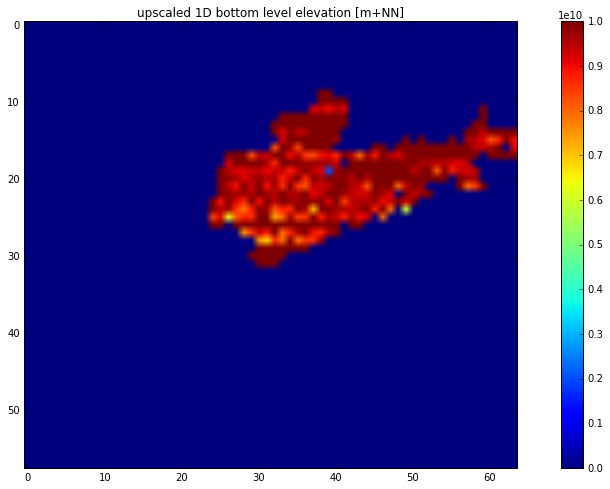

In [69]:
#TODO: not LFP compatible yet!
bottomElevation_HDYN1D_2_HLOG_BMI = model_functions.determine_bottomElev1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                         coupled_HLOG_indices,
                                                                                         bottom_lvl,
                                                                                         landmask_pcr)

plt.figure(figsize=(16,8))
plt.title('upscaled 1D bottom level elevation [m+NN]')
plt.imshow(bottomElevation_HDYN1D_2_HLOG_BMI)
plt.colorbar()

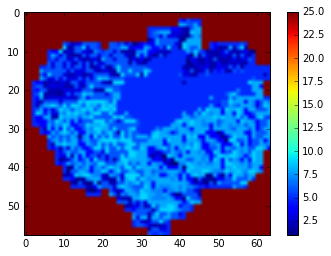

In [18]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
# -------------------------------------------------------------------------------------------------

newLDD = model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(newLDD)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

In [19]:
#TODO: create function out of this or add to noLDD function
# pcr.setclone(landmask_pcr)
# n2p = pcr.numpy2pcr(pcr.Ldd, newLDD, 25)
# pcr.report(n2p, r'/home/jannis/PhD/data_PCR/input/AMA/input30min/routing/lddsound_30min_with5.map')

In [47]:
if model_type == 'DFM':
    current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
    current_water_depth_1D = current_water_depth[separator_1D:]
    current_water_depth_2D = current_water_depth[:separator_1D]
elif model_type == 'LFP':
    current_water_depth = np.copy(hydrodynamicModel.get_var('H'))

In [62]:
inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

NameError: name 'cellAreaSpherical_1D' is not defined

In [ ]:
inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI, vmax=np.max(inundatedArea_HDYN1D_2_HLOG_BMI))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN_2_HLOG_BMI.png'), dpi=300)

In [ ]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells

In [ ]:
waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

In [ ]:
waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [ ]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [ ]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

In [ ]:
hydrologicModel.update(1)

In [ ]:
#waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)

In [ ]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = -999
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = -999

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [ ]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [ ]:
model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

In [ ]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI, vmax=np.max(inundatedArea_HDYN1D_2_HLOG_BMI))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

In [ ]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
current_water_volume_1D = current_water_volume[separator_1D:]
current_water_volume_2D = current_water_volume[:separator_1D]

waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
# plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [ ]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [ ]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

In [ ]:
model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

hydrologicModel.update(1)

In [ ]:
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)

In [ ]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = 0.
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = 0.

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [ ]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

In [ ]:
execute_all = False

In [ ]:
if execute_all == True:

    while hydrologicModel.get_time_step() < end_time_pcr:

        current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
        current_water_depth_1D = current_water_depth[separator_1D:]
        current_water_depth_2D = current_water_depth[:separator_1D]

        inundatedArea_HDYN1D_2_HLOG, \
            inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                                       coupled_HLOG_indices,
                                                                                                       current_water_depth_1D,
                                                                                                       threshold_inundated_depth,
                                                                                                       cellAreaSpherical_1D,
                                                                                                       landmask_pcr)

        inundatedArea_HDYN2D_2_HLOG, \
            inundatedArea_HDYN2D_2_HLOG_BMI, \
                inundatedFraction_HDYN2D_2_HLOG, \
                    inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                                   coupled_HLOG_indices_2way,
                                                                                                                   current_water_depth_2D,
                                                                                                                   threshold_inundated_depth,
                                                                                                                   cellAreaSpherical_2D,
                                                                                                                   cellarea_data_pcr,
                                                                                                                   landmask_pcr)

        current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
        current_water_volume_1D = current_water_volume[separator_1D:]
        current_water_volume_2D = current_water_volume[:separator_1D]

        waterVolume_HDYN1D_2_HLOG,\
            waterVolume_HDYN1D_2_HLOG_BMI,\
                waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                                  inundatedArea_HDYN1D_2_HLOG,
                                                                                                  current_water_volume_1D,
                                                                                                  couple_HLOG_2_HDYN,
                                                                                                  coupled_HLOG_indices, 
                                                                                                  landmask_pcr)

        waterVolume_HDYN2D_2_HLOG_BMI,\
            waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                              inundatedArea_HDYN2D_2_HLOG,
                                                                                              waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                              couple_HLOG_2_HDYN_2way,
                                                                                              coupled_HLOG_indices_2way,
                                                                                              landmask_pcr)

        ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

        if couple_channelStorage == False:
            waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

        model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

        model_functions.updateHydrologicVariables(hydrologicModel,
                                                  waterDepth_HDYN2D_2_HLOG_BMI,
                                                  inundatedFraction_HDYN2D_2_HLOG_BMI)

        model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

        hydrologicModel.update(1)

        delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                        missing_value_pcr, 
                                                                                        secPerDay, 
                                                                                        coupled_HLOG_indices, 
                                                                                        cellarea_data_pcr, 
                                                                                        waterVolume_HDYN2D_2_HLOG_BMI)

        delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                            couple_HDYN_2_HLOG, 
                                                                                            couple_HLOG_2_HDYN,
                                                                                            coupled_HLOG_indices,
                                                                                            delta_volume_PCR_1way, 
                                                                                            cellAreaSpherical_1D, 
                                                                                            fraction_timestep, 
                                                                                            model_type, 
                                                                                            use_Fluxes)

        model_functions.updateModel(hydrodynamicModel, 
                                    delta_water_DFM_1way, 
                                    update_step, 
                                    separator_1D, 
                                    use_Fluxes, 
                                    use_RFS, 
                                    model_type, 
                                    verbose)


    hydrodynamicModel.finalize()
    hydrologicModel.finalize()